**Binary Classification with a Bank Dataset**

Goal: To predict whether a client will subscribe to a bank term deposit

Kaggle Competition:
https://www.kaggle.com/competitions/playground-series-s5e8/overview

**Dataset Features:**

age: Age of the client (numeric)

job: Type of job (categorical: "admin.", "blue-collar", "entrepreneur", etc.)

marital: Marital status (categorical: "married", "single", "divorced")

education: Level of education (categorical: "primary", "secondary", "tertiary", "unknown")

default: Has credit in default? (categorical: "yes", "no")

balance: Average yearly balance in euros (numeric)

housing: Has a housing loan? (categorical: "yes", "no")

loan: Has a personal loan? (categorical: "yes", "no")

contact: Type of communication contact (categorical: "unknown", "telephone", "cellular")

day: Last contact day of the month (numeric, 1-31)

month: Last contact month of the year (categorical: "jan", "feb", "mar", …, "dec")

duration: Last contact duration in seconds (numeric)

campaign: Number of contacts performed during this campaign (numeric)

pdays: Number of days since the client was last contacted from a previous campaign (numeric; -1 means the client was not previously contacted)

previous: Number of contacts performed before this campaign (numeric)

poutcome: Outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success")

y: The target variable, whether the client subscribed to a term deposit (binary: "yes", "no")

**Data Importing**

In [473]:
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")
original = pd.read_csv("bank-full.csv", sep=';')

train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


**Brief Exploratory Data Analysis**

- Noticed highest percent of yes for different job groups were students and retired people, two groups that tend to not actively searching for jobs

- Noticed single people (divorced or single) tend to have higher yes percentage

- Noticed few other trends in education level and contact and accounted for that by feature engineering with other variables

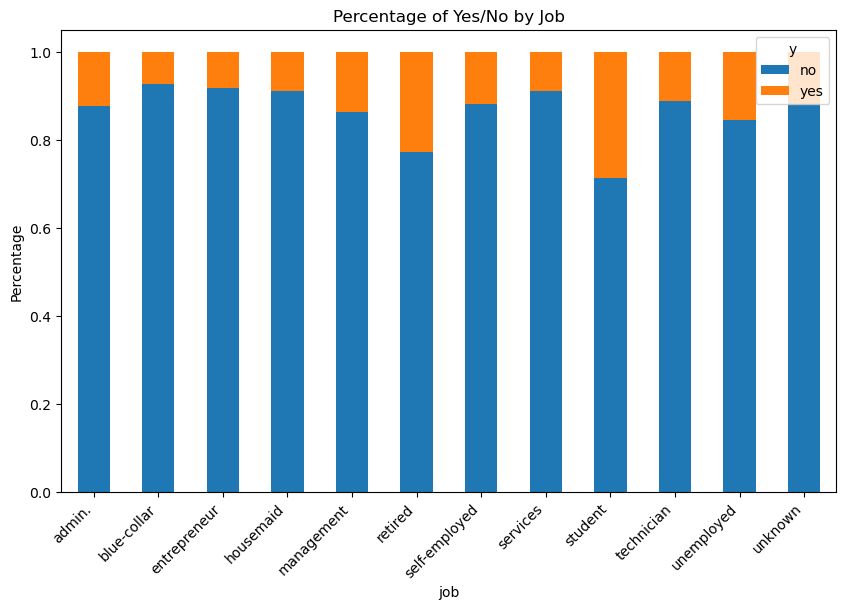

In [ ]:
import matplotlib.pyplot as plt

percentages = (
    original.groupby("job")["y"]
      .value_counts(normalize=True)
      .rename("percent")
      .reset_index()
)

pivoted = percentages.pivot(index="job", columns="y", values="percent")

pivoted.plot(kind="bar", stacked=True, figsize=(10,6))

plt.ylabel("Percentage")
plt.title("Percentage of Yes/No by Job")
plt.legend(title="y")
plt.xticks(rotation=45, ha="right")
plt.show()


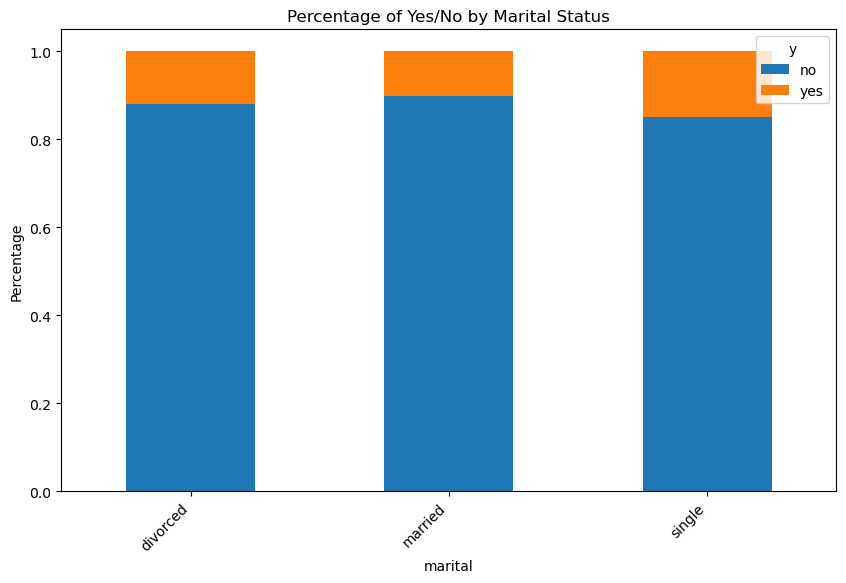

In [ ]:
percentages = (
    original.groupby("marital")["y"]
      .value_counts(normalize=True) 
      .rename("percent")
      .reset_index()
)

pivoted = percentages.pivot(index="marital", columns="y", values="percent")

pivoted.plot(kind="bar", stacked=True, figsize=(10,6))

plt.ylabel("Percentage")
plt.title("Percentage of Yes/No by Marital Status")
plt.legend(title="y")
plt.xticks(rotation=45, ha="right")
plt.show()

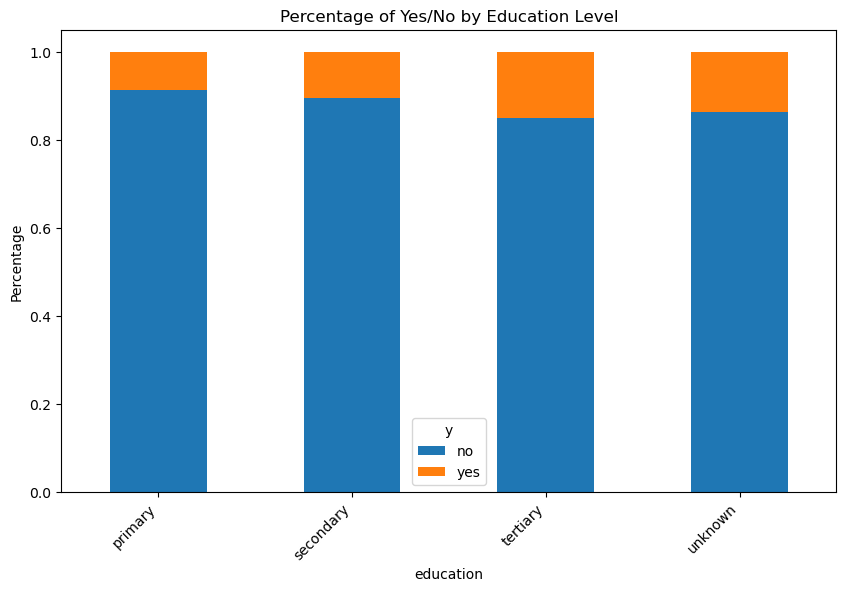

In [ ]:
percentages = (
    original.groupby("education")["y"]
      .value_counts(normalize=True)  
      .rename("percent")
      .reset_index()
)

pivoted = percentages.pivot(index="education", columns="y", values="percent")

pivoted.plot(kind="bar", stacked=True, figsize=(10,6))

plt.ylabel("Percentage")
plt.title("Percentage of Yes/No by Education Level")
plt.legend(title="y")
plt.xticks(rotation=45, ha="right") 
plt.show()

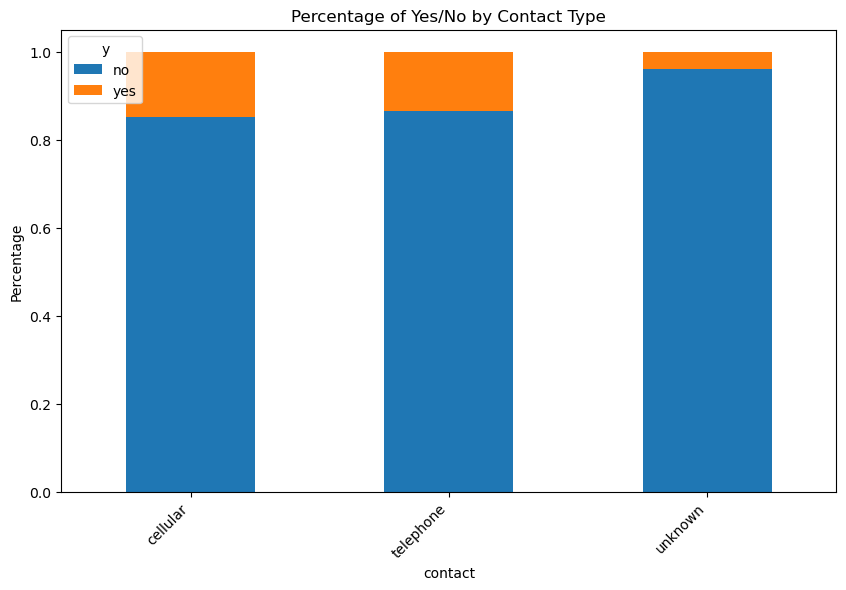

In [ ]:
percentages = (
    original.groupby("contact")["y"]
      .value_counts(normalize=True)   
      .rename("percent")
      .reset_index()
)

pivoted = percentages.pivot(index="contact", columns="y", values="percent")

pivoted.plot(kind="bar", stacked=True, figsize=(10,6))

plt.ylabel("Percentage")
plt.title("Percentage of Yes/No by Contact Type")
plt.legend(title="y")
plt.xticks(rotation=45, ha="right")  
plt.show()

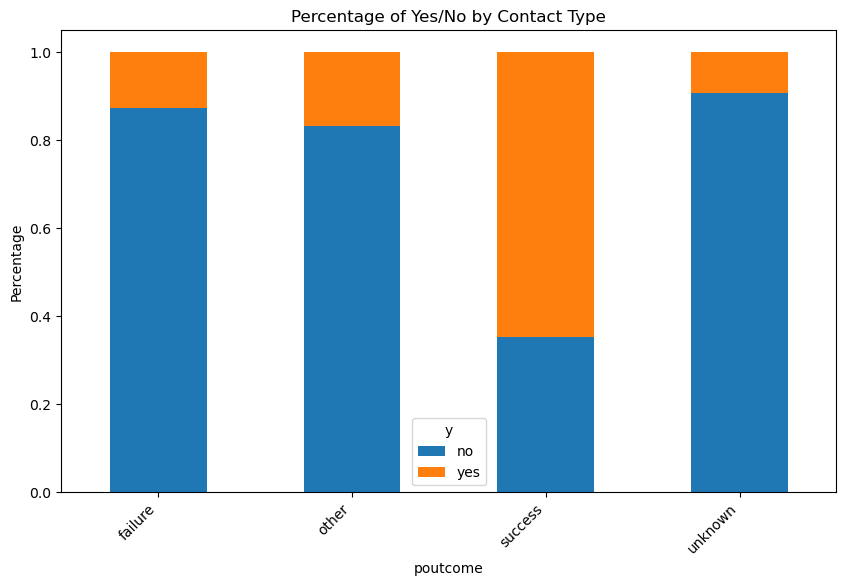

In [ ]:
percentages = (
    original.groupby("poutcome")["y"]
      .value_counts(normalize=True)
      .rename("percent")
      .reset_index()
)

pivoted = percentages.pivot(index="poutcome", columns="y", values="percent")

pivoted.plot(kind="bar", stacked=True, figsize=(10,6))

plt.ylabel("Percentage")
plt.title("Percentage of Yes/No by Contact Type")
plt.legend(title="y")
plt.xticks(rotation=45, ha="right") 
plt.show()

**Feature Engineering**

In [479]:
import numpy as np

month_to_days = {
    "jan": 0,
    "feb": 31,
    "mar": 59,
    "apr": 90,
    "may": 120,
    "jun": 151,
    "jul": 181,
    "aug": 212,
    "sep": 243,
    "oct": 273,
    "nov": 304,
    "dec": 334,
}

def feature_engineering(df):
    df["questions"] = df["default"] + " " + df["housing"] + " " + df["contact"] + " " + df["loan"]
    df["status"] = df["job"] + " " + df["education"] + " " + df["marital"]
    df["intellect"] = df["job"] + " " + df["education"]
    df["jobless_but_not_seeking"] = df["job"].isin(["retired", "student"])
    df["single"] = df["marital"].isin(["single"])
    df['log_balance']  = np.log1p(df['balance'] - df['balance'].min() + 1)
    df['log_duration'] = np.log1p(df['duration'])
    df["days_from_start_of_year"] = df["month"].map(month_to_days) + df["day"]
    return df
train = feature_engineering(train)
test = feature_engineering(test)
original = feature_engineering(original)

Preprocessing for use with LightGBM (converted categorical data to numerical data)

In [480]:
def encode_categories(df, cols):
    for col in cols:
        df[col] = df[col].astype("category").cat.codes
    return df

y
0    699434
1     95777
Name: count, dtype: int64


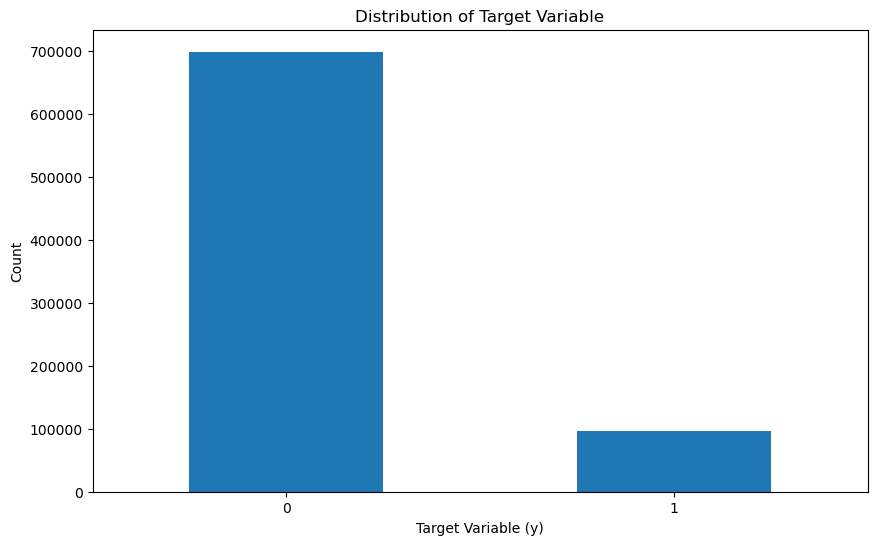

In [481]:
categorical_cols = [
    "y", "job", "marital", "education", 
    "default", "housing", "loan", 
    "contact", "month", "poutcome", "questions",
    "status", "intellect", "jobless_but_not_seeking",
    "single"
]

original = encode_categories(original, categorical_cols)
train_mod = train.drop("id",axis=1)
train_mod = encode_categories(train_mod, categorical_cols)

train_final = pd.concat([original, train_mod], axis=0)

plt.figure(figsize=(10, 6))
print(train_final["y"].value_counts())
train_final["y"].value_counts().plot(kind='bar')
plt.title("Distribution of Target Variable")
plt.xlabel("Target Variable (y)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

**Model Training with LightGBM and Parameters Optimized via Brute-force**

In [482]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X = train_final.drop("y", axis=1)
y = train_final["y"]

#7
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=7, stratify=y
)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "num_leaves": 128,
    "force_row_wise": True,
    "learning_rate": 0.02,
    "metric": ["auc","average_precision"],
    "bagging_fraction": 0.8,
    "feature_fraction": 0.6,
}

num_round = 7000
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], callbacks=[
        lgb.early_stopping(stopping_rounds=200, verbose=True),
        lgb.log_evaluation(period=100)
    ])

Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.962257	valid_0's average_precision: 0.773241
[200]	valid_0's auc: 0.964461	valid_0's average_precision: 0.785536
[300]	valid_0's auc: 0.965975	valid_0's average_precision: 0.793267
[400]	valid_0's auc: 0.966803	valid_0's average_precision: 0.797432
[500]	valid_0's auc: 0.967249	valid_0's average_precision: 0.800225
[600]	valid_0's auc: 0.967488	valid_0's average_precision: 0.801671
[700]	valid_0's auc: 0.96769	valid_0's average_precision: 0.802817
[800]	valid_0's auc: 0.967813	valid_0's average_precision: 0.803451
[900]	valid_0's auc: 0.967919	valid_0's average_precision: 0.804013
[1000]	valid_0's auc: 0.96799	valid_0's average_precision: 0.804496
[1100]	valid_0's auc: 0.968046	valid_0's average_precision: 0.804779
[1200]	valid_0's auc: 0.968092	valid_0's average_precision: 0.805044
[1300]	valid_0's auc: 0.968146	valid_0's average_precision: 0.80537
[1400]	valid_0's auc: 0.968175	valid_0's average_prec

In [ ]:
from sklearn.metrics import roc_auc_score

y_pred = bst.predict(X_test)

auc = roc_auc_score(y_test, y_pred)
print("ROC AUC:", auc)

#ROC AUC: 0.9683985800341806

ROC AUC: 0.9683985800341806


In [484]:
gain = bst.feature_importance(importance_type="gain")
feat_imp = pd.DataFrame({
    "feature": X.columns,
    "gain": gain
}).sort_values("gain", ascending=False)
print(feat_imp.head(25))

                    feature          gain
11                 duration  3.604907e+06
22             log_duration  8.455419e+05
23  days_from_start_of_year  6.551845e+05
16                questions  4.305586e+05
5                   balance  3.585132e+05
10                    month  3.249707e+05
13                    pdays  3.087146e+05
15                 poutcome  2.601570e+05
0                       age  2.431071e+05
6                   housing  2.252593e+05
8                   contact  2.182102e+05
9                       day  1.855871e+05
21              log_balance  1.817926e+05
17                   status  1.444596e+05
12                 campaign  1.205286e+05
14                 previous  7.936218e+04
3                 education  5.284662e+04
2                   marital  4.628654e+04
7                      loan  3.958115e+04
18                intellect  3.623952e+04
1                       job  2.902227e+04
19  jobless_but_not_seeking  1.484506e+04
20                   single  1.197

**Submission Data**

In [485]:
test_cols_no_y = [
    "job", "marital", "education", 
    "default", "housing", "loan", 
    "contact", "month", "poutcome", "questions",
    "status", "intellect", "jobless_but_not_seeking",
    "single"
]

test = encode_categories(test, test_cols_no_y)

y_pred = bst.predict(test.drop("id", axis=1))

submission = pd.DataFrame({
    "id": test["id"],
    "y": y_pred
})

submission.to_csv("submission.csv", index=False)